In this HW, we will implement kNN on three different types of features, extracted from the same movie review data used in HW4. The general pipeline is (1) extracting the relevant features, (2) cross validation to find the best k, (3) followed by prediction on the test set and reporting test accuracy.

In [1]:
!pip install transformers
!unzip data_sets.zip

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 43.7 MB/s 
     |████████████████████████████████| 6.6 MB 32.0 MB/s 
     |████████████████████████████████| 77 kB 5.9 MB/s 
     |████████████████████████████████| 596 kB 46.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
unzip:  cannot find or open data_sets.zip, data_sets.zip.zip or data_sets.zip.ZIP.


In [2]:
# imports
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
import random
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig, AutoTokenizer, TFBertModel
import matplotlib.pyplot as plt
import math
from scipy import stats
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig, AutoTokenizer, TFBertModel
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.utils import shuffle
import heapq
import operator
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from collections import Counter
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
from google.colab import drive
drive.mount('/content/drive')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/drive


We will use 4 fold cross validation, and cross validate over the number of nearest neighbors in [3,5,7,9,11,13]

In [11]:
kfolds = 4
klist  = [3, 5, 7, 9, 11, 13]
MIN_FREQ = 3
MAX_VOCAB = 768

# The three different features we will use are:
1. BOW representation

In HW4, we implemented NaiveBayes on BOW representation. In this HW, we will use the same features, and classify reviews using kNN classifier. 
2.  term-frequency times inverse document-frequency (tf-idf) 

We will convert the above BOW matrices into tf-idf features using https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html , and classify reviews using kNN classifier.

3. BERT Embeddings

We will use the pretrained BERT model to extract embeddings for each review, and use these embeddings as input to kNN classifier.





In [12]:
# knn functions 
# you are required to implement the following kNN functions
def getBOWRepresentation(x_train, x_test, vocabulary):
  '''
  converts into Bag of Words representation
  each column is a feature(unique word) from the vocabulary 
  x_train_bow : a numpy array with bag of words representation
  '''
  # --------your code here-------------
  x_train_bow = []
  x_test_bow = []
  for text_data in x_train:
    x_train_bow.append(transfer(text_data, list(vocabulary)))
  for text_data in x_test:
    x_test_bow.append(transfer(text_data, list(vocabulary)))
  x_train_bow = np.array(x_train_bow)
  x_test_bow = np.array(x_test_bow)
  return np.array(x_train_bow), np.array(x_test_bow)

In [13]:
# 2. Generate the i-th fold of k fold validation: used by findBestK below
# Input:
# x is an np array for training data
# y is an np array for labels
# i is an int indicating current fold
# nfolds is the total number of cross validation folds
def fold(x, y, i, nfolds):
    # your code
    train_num = x.shape[0]
    foldNum = train_num//nfolds
    test_data = i*foldNum
    
    x_train = np.concatenate((x[0:test_data], x[test_data+foldNum:]), axis=0)
    x_test = x[test_data: test_data+foldNum]

    y_train = np.concatenate((y[0:test_data], y[test_data+foldNum:]), axis=0)
    y_test = y[test_data: test_data+foldNum]

    return x_train, y_train, x_test, y_test

# 3. Classify each testing points based on the training points
# Input
# x_train: a numpy array of training data 
# x_test: a numpy array
# k: the number of neighbors to take into account when predicting the label
# Output
# y_predict: a numpy array 

def euclidean(x,y):
    return np.sqrt(np.sum((x-y)**2))

def classify(x_train, y_train, x_test, k):
    # your code
    # Euclidean distance as the measurement of distance in KNN
    numNeigh = {}
    for i in range(len(x_test)):
        distance_KNN = []
        for j in range(len(x_train)): # Help from TA
            dist = euclidean(x_test[i], x_train[j])
            distance_KNN.append((j, dist, y_train[j]))
        numNeigh[i] = sorted(distance_KNN, key = lambda kv: kv[1])[:k]

    y_predict = [] 
    for i in range(len(x_test)):
        y_data = Counter([x[2] for x in numNeigh[i]])
        y_predict.append(max(y_data.items(), key=operator.itemgetter(1))[0])
    return np.array(y_predict) # return numpy array

# 4. Calculate accuracy by comaring with true labels
# Input
# y_predict is a numpy array of 1s and 0s for the class prediction
# y is a numpy array of 1s and 0s for the true class label
def calc_accuracy(y_predict, y):
    # your code
    acc = np.sum(y == y_predict, axis=0) / len(y)
    return acc

# 5. Draw the bar plot of k vs. accuracy
# klist: a list of values of ks
# accuracy_list: a list of accuracies
def barplot(klist, accuracy_list):
    # your code
    plt.bar(klist, accuracy_list)
    plt.title('Number of Neighbors Vs Accuracy')
    plt.xlabel('Number of neighbors')
    plt.ylabel('Accuracy')
    plt.show()
    return

# 1. Find the best K
def findBestK(x, y, klist, nfolds):
    kbest = 0
    best_acc = 0
    counter = 0
    accuracy_list = []
    for k in klist:
        # your code here
        the_fold_accuracy = []
        for i in range(nfolds):
            x_train, y_train, x_test, y_test = fold(x, y, i, nfolds)
            y_predict = classify(x_train, y_train, x_test, k)
            the_fold_accuracy.append(calc_accuracy(y_predict, y_test))
        
        accuracy = sum(the_fold_accuracy) / nfolds
        if accuracy > best_acc:
            kbest = k
            best_acc = accuracy
        accuracy_list.append(accuracy)
        print(k, accuracy)

    barplot(klist, accuracy_list)
    return kbest


# The following sections extract the relevant input features 

In [14]:


# BERT is pretrained with a max length of 512
MAX_LEN = 512
tf.random.set_seed(42)
PRETRAINED_MODEL_ID = "bert-base-uncased"
### Already implemented
def create_inputs_targets(text_examples, tokenizer):
    '''converts inputs into the representation accepted by BERT
    '''
    dataset_dict = {
        "input_ids": [],
        
        "attention_mask": []
    }
    
    for item in text_examples:
        encodings = tokenizer(item, return_tensors='tf', max_length = MAX_LEN, truncation = True, pad_to_max_length=True)
        
        dataset_dict["input_ids"].append((encodings.input_ids))
        dataset_dict["attention_mask"].append((encodings.attention_mask))
    
    for key in dataset_dict:
        dataset_dict[key] = np.squeeze(np.array(dataset_dict[key]), axis=1)
           
    x = [
        dataset_dict["input_ids"],
     
        dataset_dict["attention_mask"]
    ]
    
    return x


def loadRawData(path):
    # your code here, from HW4
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    
    for file in os.listdir(path+'/training_set/pos/'):
      with open(path+'/training_set/pos/'+file) as myfile:
        raw_data = myfile.read()
        x_train.append(raw_data)
        y_train.append(1)
        
    for file in os.listdir(path+'/training_set/neg/'):
      with open(path+'/training_set/neg/'+file) as myfile:
        raw_data = myfile.read()
        x_train.append(raw_data)
        y_train.append(0)
    
    for file in os.listdir(path+'/test_set/pos/'):
      with open(path+'/test_set/pos/'+file) as myfile:
        raw_data = myfile.read()
        x_test.append(raw_data)
        y_test.append(1)
    
    for file in os.listdir(path+'/training_set/neg/'):
      with open(path+'/training_set/neg/'+file) as myfile:
        raw_data = myfile.read()
        x_test.append(raw_data)
        y_test.append(0)
    
    shuffled_indicies = np.random.permutation(len(x_train))
    x_train1 = []
    y_train1 = []
    for i in shuffled_indicies:
      x_train1.append(x_train[i])
      y_train1.append(y_train[i])
    x_train = x_train1
    y_train = y_train1
    
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    return x_train, x_test, y_train, y_test

def loadData(path):
  '''
  loads reviews as strings in a list 
  ---- your code here ------
  '''
  x_train = []
  x_test = []
  y_train = []
  y_test = []
  vocab_builder = []
  vocabulary ={}
  
  for file in os.listdir(path+'/training_set/pos/'):
     with open(path+'/training_set/pos/'+file) as myfile:
       review = myfile.read()
       review = re.sub(r'[^\w\s]', '', review)
       review_tokens = tokenizer.tokenize(review.lower())
       review_tokens = [review for review in review_tokens if not review in stop_words]
       review_tokens = [ps.stem(review) for review in review_tokens]
       x_train.append(review_tokens)
       y_train += [1]
       vocab_builder += review_tokens
  
  for file in os.listdir(path+'/training_set/neg/'):
    with open(path+'/training_set/neg/'+file) as myfile:
      read_file = myfile.read()
      review = re.sub(r'[^\w\s]', '', read_file)
      review_tokens = tokenizer.tokenize(review.lower())
      review_tokens = [review for review in review_tokens if not review in stop_words]
      review_tokens = [ps.stem(review) for review in review_tokens]
      x_train.append(review_tokens)
      y_train += [0]
      vocab_builder += review_tokens
  
  for file in os.listdir(path+'/test_set/pos/'):
    with open(path+'/test_set/pos/'+file) as f:
      read_file = f.read()
      review = re.sub(r'[^\w\s]', '', read_file)
      review_tokens = tokenizer.tokenize(review.lower())
      review_tokens = [review for review in review_tokens if not review in stop_words]
      review_tokens = [ps.stem(review) for review in review_tokens]
      x_test.append(review_tokens)
      y_test += [1]
      vocab_builder += review_tokens
  
  for file in os.listdir(path+'/test_set/neg/'):
    with open(path+'/test_set/neg/'+file) as myfile:
      read_file = myfile.read()
      review = re.sub(r'[^\w\s]', '', read_file)
      review_tokens = tokenizer.tokenize(review.lower())
      review_tokens = [review for review in review_tokens if not review in stop_words]
      review_tokens = [ps.stem(review) for w in review_tokens]
      x_test.append(review_tokens)
      y_test += [0]
      vocab_builder += review_tokens
  
  for word in vocab_builder:
    if word in vocabulary.keys():
      vocabulary[word]=vocabulary[word]+1
    else:
      vocabulary[word]=1
      
  shuffle = np.random.permutation(len(x_train))
  x_train = [x_train[i] for i in shuffle]
  y_train = [y_train[i] for i in shuffle]
  
  return x_train, x_test, y_train, y_test, vocabulary


def transfer(review, vocabulary):
  temp_list = [0]*len(vocabulary)
  for word in review:
    if word in vocabulary:
      index = vocabulary.index(word)
      temp_list[index] += 1
  return temp_list
## Already Implemented
def create_bert():
    '''Creates a model specified by pretrained_model_id

    '''
    # load pretrained BERT model 
    
    # Note that here we use TFBertModel instead of TFBertforSequenceClassification
    model = TFBertModel.from_pretrained(PRETRAINED_MODEL_ID, num_labels = 2 )
    
    
    # BERT inputs 
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32)
    print(input_ids.shape)
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32)
    
    embedding = model(
            input_ids,  attention_mask=attention_mask
        )
 
    # this returns two embeddings : N X MAX_LEN X 768 (hidden representation for each token) and N X 768 (next sentence prediction token)
    # as we want to represent the entire sentence, we will use the average of the representation for each token in the first output
    # Note that there are other alternative ways  to do this: using the first token (CLS) to represent the entire sentence, or using the 
    # next sentence prediction token
    return model



# change the following code to add TFIDF features 
def processData(fullDatasetPath, model_type):
  # shuffle train data here, or when loading the train data or as part of kNN cross validation function
  # we will use the bert-base-uncased tokenizer - 
  if model_type == 'BERT':
    # load datasets as lists of reviews
    # no preprocessing required!
    # we will use the bert-base-uncased tokenizer - 
    XtrainText, XtestText, ytrain, ytest = loadRawData(fullDatasetPath)
    tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_ID)
    
    # tokenize for bert
    xtrain = create_inputs_targets(XtrainText, tokenizer)
    
    
    ytrain = np.array(ytrain)

    xtest = create_inputs_targets(XtestText, tokenizer)
    
    ytest = np.array(ytest)
    model = create_bert()
    xtrain = np.mean(model.predict(xtrain)[0], axis=1) #we want to represent the entire sentence, we will use the average of the output token representation 
    xtest = np.mean(model.predict(xtest)[0], axis=1) 
    return xtrain, xtest, ytrain, ytest
    
  else:
    # reuse data loading functions from NaiveBayes portions, you can optionally save the BOW matrices and reload here 
    # reuse from HW4
    XtrainText, XtestText, ytrain, ytest, vocabulary = loadData(fullDatasetPath)
    vocabulary = dict((word, index) for word, index in vocabulary.items() if \
                   vocabulary[word]>=MIN_FREQ and word in heapq.nlargest(MAX_VOCAB, vocabulary, key=vocabulary.get))
    vocabulary['UNK'] = 0
    xtrain, xtest = getBOWRepresentation(XtrainText, XtestText, vocabulary) 
    # add TFidF transformer
    if model_type == 'TFIDF':
      # extract TF-IDF features using sklearn helper
      transformer = TfidfTransformer()
      xtrain = transformer.fit_transform(xtrain).toarray()
      xtext = transformer.fit_transform(xtest).toarray()
    xtrain, ytrain = shuffle(xtrain, ytrain)
    return xtrain, xtest, ytrain, ytest





In [7]:
def classification_pipeline(path, klist, kfolds, model_type):
  xtrain, xtest, ytrain, ytest = processData(path, model_type)
  bestk = findBestK(xtrain, ytrain, klist, kfolds)
  y_pred = classify(xtrain, ytrain, xtest, k=bestk)
  test_acc = calc_accuracy(y_pred, ytest) 
  return test_acc, bestk

# k-Nearest Neighbor on BOW representation, TF-IDF and BERT embeddings

3 0.5885714285714286
5 0.5928571428571429
7 0.5935714285714286
9 0.6007142857142858
11 0.6135714285714285
13 0.6107142857142858


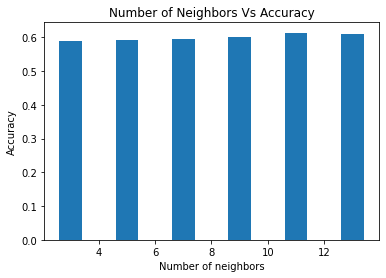

features: BOW, best_k: 11,  test accuracy: 0.6566666666666666
3 0.6585714285714286
5 0.6678571428571429
7 0.6707142857142857
9 0.6728571428571428
11 0.6678571428571428
13 0.6807142857142857


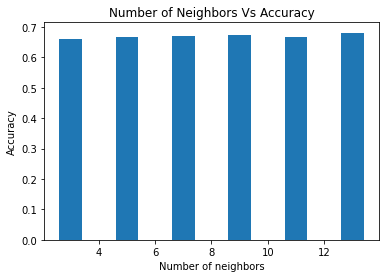

features: TFIDF, best_k: 13,  test accuracy: 0.8416666666666667


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be 

(None, 512)
3 0.6714285714285714
5 0.6821428571428572
7 0.6835714285714285
9 0.6749999999999999
11 0.6757142857142857
13 0.6842857142857143


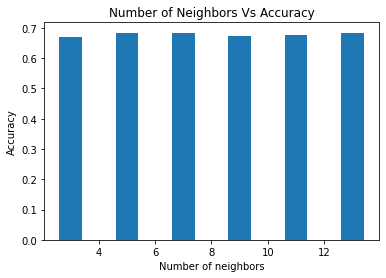

features: BERT, best_k: 13,  test accuracy: 0.786


In [15]:
feature_types = ['BOW', 'TFIDF', 'BERT']
path = '/content/drive/My Drive/data_sets/'
for feature_type in feature_types:
  test_acc, best_k = classification_pipeline(path, klist, kfolds, feature_type)
  print(f'features: {feature_type}, best_k: {best_k},  test accuracy: {test_acc}')
